In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, ConcatDataset, Subset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
import matplotlib.pyplot as plt
import math
import time
import os
import pandas as pd
import torch.nn.functional as F
#from torch.utils.tensorboard import SummaryWriter
import cv2
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_tcn import TCN

# Helper functions

In [2]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['valid'] = Subset(dataset, val_idx)
    return datasets

In [3]:
def preprocessing_batch(x, y, batch_first=True):
    # *********** THIS HAS TO BE IMPLEMENTED at EVERY iteration during training **************
    # We will extract only the tensor we actually need to feed our model (feature and label tensor)
    x_input = x["encoder_cont"]

    # shape [batchsize, features]
    y_input = torch.squeeze(y[0])

    if batch_first == False:
        # Reshaping to have: shape [Timestep, batchsize, features]
        x_input = x_input.permute([1, 0, 2])
    # Data types for:
    #    Features: torch.float32
    #    Label:    torch.int64
    #print(f"Features dtype: {x_input.dtype} \nLabels dtype: {y_input.dtype}")
    return x_input, y_input

In [4]:
def train_and_validate(model, loss_criterion, optimizer, epochs, train_data_loader, valid_data_loader, device):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    #writer = SummaryWriter()
    model = model.to(device)
    start = time.time()
    history = []
    best_loss = np.inf   # init to infinity

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs, labels = preprocessing_batch(inputs, labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            #print(f"Output shape: {outputs.shape} \t Label shape: {labels.shape}")
            
            # Compute loss
            #print(f"output shape: {outputs.shape} \t labels shape: {labels.shape}")
            #print(f"labels: {labels}")
            #print(outputs)
            loss = loss_criterion(outputs, labels) #.to(torch.float32)
            
            #print(f"Outputs: {outputs} \t type: {outputs.dtype}")
            #print(f"Loss: {loss} \t type: {loss.dtype}")
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() #* inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() #* inputs.size(0)
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        
        #writer.add_scalar("Train_loss x epoch", train_loss/len(train_data_loader), epoch)
        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs, labels = preprocessing_batch(inputs, labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs.cuda())

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item()# * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() #* inputs.size(0)
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        #writer.add_scalar("Valid_loss x epoch", valid_loss/len(valid_data_loader), epoch)
        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_data_loader) 
        avg_train_acc = train_acc/len(train_data_loader)
        
        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/len(valid_data_loader) 
        avg_valid_acc = valid_acc/len(valid_data_loader)
        
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])        
        epoch_end = time.time()
        if avg_valid_loss < best_loss:
            print("New best model saved")
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), 'slippage_model_bw.pt')
            
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        #print("Epoch : {:03d}, Training: Loss: {:.4f}, \n\t\tValidation : Loss : {:.4f}, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_valid_loss, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
    #writer.close()      
    return model, history

# Custom Dataset Preprocessing

# Creating TimeSeries Dataset and DataLoader

In [5]:
# Window size
window_size = 100
input_features = ["mag", "mag_avg2", "mag_avg3", "mag_avg4"]
feature_scalers = [None, None, None, None]
scalers_dict = dict(zip(input_features, feature_scalers))

train_df = pd.read_csv("dataset_slippage/train_data.csv")
valid_df = pd.read_csv("dataset_slippage/valid_data.csv")

# create the dataset from the pandas dataframe
train_dataset = TimeSeriesDataSet(
    train_df,
    group_ids=["series_id"],
    target="label",
    time_idx="time_unitless",
    min_encoder_length=window_size,
    max_encoder_length=window_size,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_unknown_reals=input_features,
    scalers=scalers_dict,
)

# WE still have to create a separate test_dataset from other DataFrames (e.g csv file 35-40)
# create the dataset from the pandas dataframe
valid_dataset = TimeSeriesDataSet(
    valid_df,
    group_ids=["series_id"],
    target="label",
    time_idx="time_unitless",
    min_encoder_length=window_size,
    max_encoder_length=window_size,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_unknown_reals=input_features,
    scalers=scalers_dict,
)

In [6]:
#x.shape, y.shape

In [7]:
#y

# Model Architecture

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerModel(nn.Module):

    def __init__(self, nclasses: int, fsize: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5, batch_first=True):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(fsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(fsize, nhead, d_hid, dropout, batch_first=batch_first)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        #self.embedding = nn.Embedding(ntoken, d_model)
        #self.d_model = d_model
        self.linear = nn.Linear(fsize, nclasses)
        self.softmax = nn.Softmax(dim=1) # Probability 0-1 along dim=0
        self.init_weights()
        self.batch_first = batch_first
        

    def init_weights(self) -> None:
        initrange = 0.1
        #self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Arguments:
            src: Tensor, shape ``[batch_size, seq_len, features]``
            src_mask: Tensor, shape ``[batch_size, seq_len, features]``
            
        if batch_first == False
            src: Tensor, shape ``[seq_len, batch_size, features]``
            src_mask: Tensor, shape ``[seq_len, batch_size, features]``

        Returns:
            output Tensor of shape ``[batch_size, nclasses]``
        """
        #src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            if self.batch_first == False:
                src_mask = nn.Transformer.generate_square_subsequent_mask(src.shape[0]).to(device)
            else:
                src_mask = nn.Transformer.generate_square_subsequent_mask(src.shape[1]).to(device)
                
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        if self.batch_first == False:
            output = output.sum(dim=0) # We sum along the "timestep" axis/dim
        else:
            output = output.sum(dim=1) # We sum along the "timestep" axis/dim
        output = self.softmax(output) # Output shape: [Batchsize, nclasses]
        return output

In [9]:
class LocalTCN(nn.Module):
    def __init__(self):
        super(LocalTCN, self).__init__()
        self.tcn = TCN(
            num_inputs = fsize,
            num_channels = [12, 12, 12, 12],
            dilations = [1, 2, 4, 8],
            kernel_size = 8,
            dropout = 0.2,
            use_norm = "layer_norm",
            activation = "relu",
            kernel_initializer = "kaiming_normal",
            use_skip_connections = True,
            input_shape = "NLC",
        )
        self.fc1 = nn.Conv1d(12, 1, 77)
        self.ln1 = nn.LayerNorm(24)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Conv1d(1, 1, 1)
        self.ln2 = nn.LayerNorm(24)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Conv1d(1, 1, 23)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, src):
        output = self.tcn(src)
        #print(f"output tcn: {output.shape}")
        output = output.permute([0, 2, 1])
        output = self.fc1(output)
        output = self.ln1(output)
        output = self.relu1(output)
        output = self.dropout1(output)
        #print(f"output fc1: {output.shape}")
        output = self.fc2(output)
        output = self.ln2(output)
        output = self.relu2(output)
        output = self.dropout2(output)
        #print(f"output fc2: {output.shape}")
        output = self.fc3(output)
        #print(f"output fc3: {output.shape}")
        output = torch.flatten(output, start_dim=1)
        output = self.softmax(output)
        
        #print(f"output flatten: {output.shape}")
        return output
    

# Model Training

When CUDA is not responding run the following commands:
- sudo rmmod nvidia_uvm
- sudo modprobe nvidia_uvm

In [15]:
# ******** Hyperparameters setup ******** 
# Choose whatever GPU device number you want
model_arch = "tcn"
num_epochs = 800
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# convert the dataset to a dataloader
train_dataloader = train_dataset.to_dataloader(batch_size=batch_size)
valid_dataloader = valid_dataset.to_dataloader(batch_size=batch_size)

In [17]:
if model_arch == "transformer":
    nclasses =  2  # Number of classes
    fsize = 4      # feature_size dimension
    d_hid = 200    # dimension of the feedforward network model in ``nn.TransformerEncoder``
    nlayers = 1    # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
    nhead = 1      # number of heads in ``nn.MultiheadAttention``
    dropout = 0
    model = TransformerModel(nclasses, fsize, nhead, d_hid, nlayers, dropout).to(device)


if model_arch == "tcn":
    fsize = 4
    model = LocalTCN()


In [18]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(model)

LocalTCN(
  (tcn): TCN(
    (downsample_skip_connection): ModuleList(
      (0-3): 4 x None
    )
    (activation_skip_out): ReLU()
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): CausalConv1d(4, 12, kernel_size=(8,), stride=(1,))
        (conv2): CausalConv1d(12, 12, kernel_size=(8,), stride=(1,))
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (downsample): Conv1d(4, 12, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): CausalConv1d(12, 12, kernel_size=(8,), stride=(1,), dilation=(2,))
        (conv2): CausalConv1d(12, 12, kernel_size=(8,), stride=(1,), dilation=(2,))
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    

In [19]:
trained_model, history = train_and_validate(model, loss_fn, optimizer, num_epochs, train_dataloader, valid_dataloader, device)

Epoch: 1/800
New best model saved
Epoch : 001, Training: Loss: 0.6899, Accuracy: 54.2465%, 
		Validation : Loss : 0.6577, Accuracy: 65.2865%, Time: 33.6953s
Epoch: 2/800
New best model saved
Epoch : 002, Training: Loss: 0.6852, Accuracy: 56.6822%, 
		Validation : Loss : 0.6539, Accuracy: 65.5208%, Time: 35.0997s
Epoch: 3/800
Epoch : 003, Training: Loss: 0.6840, Accuracy: 56.9196%, 
		Validation : Loss : 0.6572, Accuracy: 65.3125%, Time: 35.0993s
Epoch: 4/800
New best model saved
Epoch : 004, Training: Loss: 0.6825, Accuracy: 56.9513%, 
		Validation : Loss : 0.6431, Accuracy: 65.6250%, Time: 35.1569s
Epoch: 5/800
New best model saved
Epoch : 005, Training: Loss: 0.6727, Accuracy: 57.7024%, 
		Validation : Loss : 0.5835, Accuracy: 65.3646%, Time: 35.5887s
Epoch: 6/800
New best model saved
Epoch : 006, Training: Loss: 0.6407, Accuracy: 63.1171%, 
		Validation : Loss : 0.5195, Accuracy: 76.5625%, Time: 35.4625s
Epoch: 7/800
New best model saved
Epoch : 007, Training: Loss: 0.5922, Accuracy

# Model Evaluation

In [101]:
model2 = LocalTCN() #models.vgg16()
#model2.classifier[-1] = nn.Linear(4096, 3)
model2.load_state_dict(torch.load("slippage_model_bw.pt", map_location=torch.device('cpu')))
model2.eval()

LocalTCN(
  (tcn): TCN(
    (downsample_skip_connection): ModuleList(
      (0-3): 4 x None
    )
    (activation_skip_out): ReLU()
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): CausalConv1d(4, 12, kernel_size=(8,), stride=(1,))
        (conv2): CausalConv1d(12, 12, kernel_size=(8,), stride=(1,))
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (downsample): Conv1d(4, 12, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): CausalConv1d(12, 12, kernel_size=(8,), stride=(1,), dilation=(2,))
        (conv2): CausalConv1d(12, 12, kernel_size=(8,), stride=(1,), dilation=(2,))
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    

In [119]:
# This df is for showing prediction results in plots later
viz_df = valid_df
viz_df["predicted_label"] = np.NaN

for sample in valid_dataset: 
    x, _ = sample
    # Start index of input sequence
    start_idx = x["encoder_time_idx_start"]
    # Target index of predicted label
    target_idx = int(start_idx + window_size)
    
    input_seq = x["x_cont"][:-1][None, :, :]
    predicted_output = model2(input_seq)
    
    ret, predicted_output = torch.max(predicted_output.data, 1)
    viz_df.iloc[target_idx, -1] = predicted_output.numpy()


# Results Visualization

In [132]:
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

In [133]:
plt.rcParams['figure.figsize'] = [20, 5]

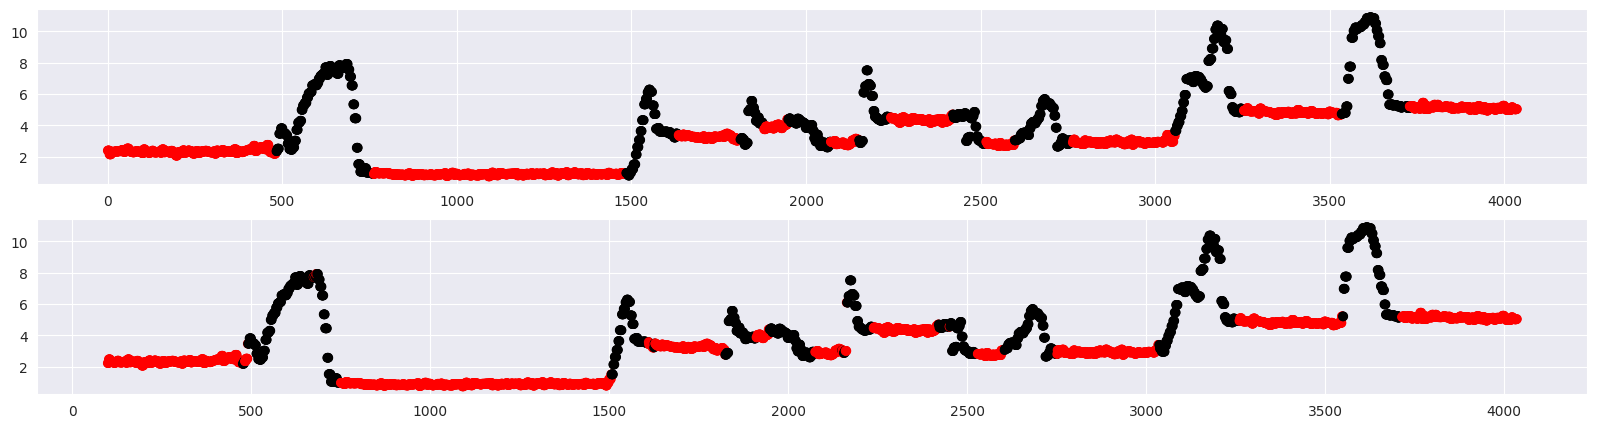

In [151]:
sns.set_style('darkgrid') 

#fig, axs = plt.subplots(2, 1, figsize=(20, 5))
x = viz_df["time_unitless"]
y = viz_df["mag"]
label = viz_df["label"]
colors = ["red", "black"]
plt.subplot(2, 1, 1)
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

plt.subplot(2, 1, 2)
x = viz_df["time_unitless"]
y = viz_df["mag"]
label = viz_df["predicted_label"]
colors = ["red", "black"]
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))


In [163]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
viz_df_clean = viz_df.dropna()

acc = accuracy_score(viz_df_clean["label"], viz_df_clean["predicted_label"])
precision = precision_score(viz_df_clean["label"], viz_df_clean["predicted_label"])
recall = recall_score(viz_df_clean["label"], viz_df_clean["predicted_label"])
f1 = f1_score(viz_df_clean["label"], viz_df_clean["predicted_label"])

print(f"{acc=:.3f} \t {precision=:.3f} \t {recall=:.3f} \t {f1=:.3f}")

acc=0.942 	 precision=0.935 	 recall=0.895 	 f1=0.915


# Experiments random

In [108]:
t = x["x_cont"][:-1]

In [109]:
t.shape

torch.Size([100, 4])

In [99]:
x, y = valid_dataset[0]
start_idx = x["encoder_time_idx_start"]
target_idx = int(start_idx + window_size)

input_seq = x["x_cont"][None, :, :]
input_seq

tensor([[[2.3960, 2.3640, 2.3530, 2.3470],
         [2.3960, 2.3960, 2.3740, 2.3640],
         [2.3960, 2.3960, 2.3960, 2.3800],
         [2.3960, 2.3960, 2.3960, 2.3960],
         [2.3960, 2.3960, 2.3960, 2.3960],
         [2.1523, 2.2740, 2.3150, 2.3350],
         [2.1523, 2.1520, 2.2340, 2.2740],
         [2.1523, 2.1520, 2.1520, 2.2130],
         [2.1523, 2.1520, 2.1520, 2.1520],
         [2.1523, 2.1520, 2.1520, 2.1520],
         [2.3201, 2.2360, 2.2080, 2.1940],
         [2.3201, 2.3200, 2.2640, 2.2360],
         [2.3201, 2.3200, 2.3200, 2.2780],
         [2.3201, 2.3200, 2.3200, 2.3200],
         [2.3201, 2.3200, 2.3200, 2.3200],
         [2.3201, 2.3200, 2.3200, 2.3200],
         [2.3153, 2.3180, 2.3180, 2.3190],
         [2.3153, 2.3150, 2.3170, 2.3180],
         [2.3153, 2.3150, 2.3150, 2.3170],
         [2.3153, 2.3150, 2.3150, 2.3150],
         [2.3153, 2.3150, 2.3150, 2.3150],
         [2.3153, 2.3150, 2.3150, 2.3150],
         [2.3554, 2.3350, 2.3290, 2.3250],
         [2

In [92]:
valid_df.iloc[target_idx, :]

Unnamed: 0         1950.000000
mag                   4.383547
mag_avg2              4.384000
mag_avg3              4.384000
mag_avg4              4.384000
label                 1.000000
time_unitless      1950.000000
series_id            40.000000
predicted_label            NaN
Name: 1950, dtype: float64

In [74]:
demo_df = valid_df
demo_df["predicted_label"] = np.NaN
demo_df

,Unnamed: 0,mag,mag_avg2,mag_avg3,mag_avg4,label,time_unitless,series_id,predicted_label
0,0,2.395965,2.364,2.353,2.347,0,0,40,NaN
1,1,2.395965,2.396,2.374,2.364,0,1,40,NaN
2,2,2.395965,2.396,2.396,2.380,0,2,40,NaN
3,3,2.395965,2.396,2.396,2.396,0,3,40,NaN
4,4,2.395965,2.396,2.396,2.396,0,4,40,NaN
5,5,2.152305,2.274,2.315,2.335,0,5,40,NaN
6,6,2.152305,2.152,2.234,2.274,0,6,40,NaN
7,7,2.152305,2.152,2.152,2.213,0,7,40,NaN
8,8,2.152305,2.152,2.152,2.152,0,8,40,NaN
9,9,2.152305,2.152,2.152,2.152,0,9,40,NaN


# Data Exploration-Insights

In [45]:
pd.set_option('display.max_rows', None)

info_df = (train_df.groupby(["series_id"]).apply(
    lambda x: x["label"].value_counts()/len(x["label"])*100)
)   

In [55]:
info_df.reset_index().sort_values(by=["series_id", "label"])#.groupby(["label"]).apply(lambda x: x["count"].mean())

,series_id,label,count
0,1,0,51.335972
1,1,1,48.664028
2,2,0,63.852914
3,2,1,36.147086
4,3,0,64.062249
5,3,1,35.937751
6,4,0,60.873771
7,4,1,39.126229
8,5,0,55.216693
9,5,1,44.783307


In [57]:
valid_df["label"].value_counts()/len(valid_df)*100

label
0    66.237305
1    33.762695
Name: count, dtype: float64

In [47]:
# and load the first batch
x, y = next(iter(train_dataloader))
x, y = preprocessing_batch(x, y)

In [48]:
x.shape

torch.Size([256, 100, 4])

In [49]:
output = model(x)

output tcn: torch.Size([256, 100, 12])
output fc1: torch.Size([256, 1, 24])
output fc2: torch.Size([256, 1, 24])
output fc3: torch.Size([256, 1, 2])
output flatten: torch.Size([256, 2])


In [32]:
output.shape

torch.Size([256, 100, 12])

In [20]:
output.shape
#torch.flatten(output, start_dim=1).shape

torch.Size([256, 100, 12])

In [27]:
flat1 = nn.Conv1d(12, 1, 77) # Number of nodes we want (24) = Previous output.shape[1] + 1 - number_of_nodes_we_want_to_have
flat2 = nn.Conv1d(1, 1, 1)
flat3 = nn.Conv1d(1, 1, 23)

In [28]:
output_p = output.permute([0, 2, 1])

In [32]:
output_f1 = flat1(output_p)
output_f1.shape

torch.Size([256, 1, 24])

In [33]:
output_f2 = flat2(output_f1)
output_f2.shape

torch.Size([256, 1, 24])

In [34]:
output_f3 = flat3(output_f2)
output_f3.shape

torch.Size([256, 1, 2])

In [43]:
torch.flatten(output_f3, start_dim=1).shape

torch.Size([256, 2])

In [37]:
torch.squeeze(output_f3).shape

TypeError: unsqueeze() missing 1 required positional arguments: "dim"

In [19]:
output = model(x.to("cuda"))

In [37]:
output.data

tensor([[0.7248, 0.2752],
        [0.8109, 0.1891]], device='cuda:0')

In [20]:
x.shape, #output.shape

(torch.Size([2, 50, 4]),)

In [21]:
output

tensor([[0.7248, 0.2752],
        [0.8109, 0.1891]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [23]:
ret, predictions = torch.max(output, 1)

In [29]:
y[0] = 1

In [38]:
correct_counts = predictions.eq(y.to("cuda").data.view_as(predictions))

In [39]:
correct_counts

tensor([False,  True], device='cuda:0')

In [43]:
acc =torch.mean(correct_counts.type(torch.FloatTensor))

2

In [45]:
train_acc =0

In [46]:
# Convert correct_counts to float and then compute the mean
acc = torch.mean(correct_counts.type(torch.FloatTensor))

# Compute total accuracy in the whole batch and add to train_acc
train_acc += acc.item() * x.size(0)

In [47]:
train_acc

1.0

In [48]:
acc.item()

0.5

In [24]:
criterion =  nn.CrossEntropyLoss()


In [25]:
y = torch.squeeze(y)

In [26]:
criterion(output, y.to("cuda"))

tensor(0.8093, device='cuda:0', grad_fn=<NllLossBackward0>)